In [1]:
# !pip install wandb
# !pip install transformers
# !pip install sentencepiece
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0,2" 
import pandas as pd
import numpy as np
import re
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import math
import torch.optim as optim
import wandb
import requests
import time

wandb.login()
%env WANDB_PROJECT= Relation_Lining
# os.environ["WANDB_DISABLED"] = "true"



device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device('cuda:3')

wandb: Currently logged in as: hodz199. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=Relation_Lining


In [2]:
def get_relation_label(rel_id):
    label = ''
    API_ENDPOINT = "https://www.wikidata.org/w/api.php"
    params = {
        'action': 'wbgetentities',
        'format': 'json',
        'languages': 'en',
        'props': 'labels',
        'ids': ''
    }
      
    params['ids'] = str(rel_id)

    try:
        response = requests.get(API_ENDPOINT, params = params).json()['entities']
        label = response[str(rel_id)]['labels']['en']['value']
    except:
        return label
    return label

In [3]:
from multiprocessing import Pool
from functools import partial
import inspect
import time
import os
import requests

def parallal_task(func, iterable, *params): 
    with open(f'./tmp_func.py', 'w') as file:
        file.write("import requests \n")
        file.write(inspect.getsource(func).replace(func.__name__, 'task'))

    from tmp_func import task
    pool = Pool(processes=15)
    res = pool.map(task, iterable)
    pool.close()
    
    os.remove('./tmp_func.py')
    return res

In [4]:
# Create torch dataset
# https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [5]:
def preprocess_combined_relations(row):
    row['combined relations'] = row['combined relations'].replace("'", '')
    row['combined relations'] = row['combined relations'].replace("[", '[ ')
    row['combined relations'] = row['combined relations'].replace("]", ' ]')
    row['combined relations'] = row['combined relations'].replace(",", ' ,')
    
    return row['combined relations']

In [6]:
def define_input_text(row):
    return '* ' + row["question"] + ' *,* ' + row["entity label"] + ' *,* ' + row["combined relations"] + ' *'

In [7]:
max_source_length = 1700
max_target_length = 128

In [8]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration 
from transformers import EarlyStoppingCallback

tokenizer = T5TokenizerFast.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)

## Training Data

In [9]:
training_data = pd.read_csv('./3-Relation_Linking_Data/2-final_input/training_data.csv')
# training_data = training_data.dropna()
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30884 entries, 0 to 30883
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               30884 non-null  object
 1   entity label           30884 non-null  object
 2   relation labels        30882 non-null  object
 3   target relation id_x   30884 non-null  object
 4   target relation label  30748 non-null  object
 5   qid                    30594 non-null  object
 6   target relation id_y   30594 non-null  object
 7   relation_obj_labels    20800 non-null  object
 8   relation_obj_ids       20800 non-null  object
 9   combined relations     30884 non-null  object
dtypes: object(10)
memory usage: 2.4+ MB


In [10]:
training_data['combined relations'] = training_data.apply(preprocess_combined_relations, axis =1)
training_data

,question,entity label,relation labels,target relation id_x,target relation label,qid,target relation id_y,relation_obj_labels,relation_obj_ids,combined relations
0,what movie is produced by warner bros.,warner bros.,"Commons category , instance of , founded by...",P272,production company,Q126399,P272,"employer, owned by, record label, producer, pr...","P108, P127, P264, P162, P272, P112, P750, P749...","[ Commons category , employer , instance of , ..."
1,who is a musician born in detroit,detroit,"topics main category , continent , country ...",P19,place of birth,Q12439,P19,"place of birth, home port, location, country o...","P19, P504, P276, P495, P483, P551, P291, P527,...","[ topics main category , place of birth , cont..."
2,who produced the film rough house rosie,rough house rosie,"IMDb ID , Commons category , instance of , ...",P162,producer,Q7370831,P162,NaN,NaN,"[ IMDb ID , Commons category , instance of , d..."
3,what is the language in which mera shikar was ...,mera shikar,"IMDb ID , instance of , director , cast me...",P364,original language of film or TV show,Q6817891,P364,NaN,NaN,"[ IMDb ID , instance of , director , cast memb..."
4,Whats the name of a battle that happened in ch...,chicago,"Dewey Decimal Classification , WOEID , topi...",P276,location,Q1297,P276,"place of birth, residence, place of publicatio...","P19, P551, P291, P276, P180, P190, P195, P559,...","[ Dewey Decimal Classification , place of birt..."
...,...,...,...,...,...,...,...,...,...,...
30879,What is the nationality of anthony bailey,anthony bailey,"instance of , sex or gender , given name , ...",P27,country of citizenship,Q16093542,P27,NaN,NaN,"[ instance of , sex or gender , given name , o..."
30880,who was homi k. bhabha especially influenced by,homi k. bhabha,"VIAF ID , ISNI , Library of Congress author...",P737,influenced by,Q325741,P737,"spouse, author","P26, P50","[ VIAF ID , spouse , ISNI , author , Library o..."
30881,which artist composes video game music,video game music,"topics main category , Freebase ID , Common...",P136,genre,Q1062702,P136,"field of work, instance of, genre, subclass of...","P101, P31, P136, P279, P921, P1382, P1889, P30...","[ topics main category , field of work , Freeb..."
30882,What gender is gastón filgueira,gastón filgueira,"member of sports team , occupation , date o...",P21,sex or gender,Q926822,P21,NaN,NaN,"[ member of sports team , occupation , date of..."


In [11]:
training_data['input_text'] = training_data.apply(define_input_text, axis=1)
# training_data.head()

In [12]:
training_data['input_text']

0        * what movie is produced by warner bros. *,* w...
1        * who is a musician born in detroit *,* detroi...
2        * who produced the film rough house rosie *,* ...
3        * what is the language in which mera shikar wa...
4        * Whats the name of a battle that happened in ...
                               ...                        
30879    * What is the nationality of anthony bailey *,...
30880    * who was homi k. bhabha especially influenced...
30881    * which artist composes video game music *,* v...
30882    * What gender is gastón filgueira *,* gastón f...
30883    * what player played a defender? *,* defender ...
Name: input_text, Length: 30884, dtype: object

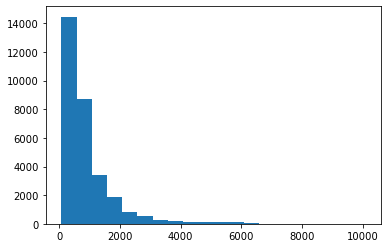

In [13]:
import matplotlib.pyplot as plt
plt.hist(training_data['input_text'].str.len(), bins = 20)
plt.show()

In [14]:
len(training_data['input_text'][training_data['input_text'].str.len() > 2048])*100/len(training_data['input_text'])

7.8357725683201656

In [15]:
len(training_data[training_data['input_text'].str.len() <= 1700])*100/len(training_data)

88.269006605362

In [16]:
# training_data = training_data[training_data['input_text'].str.len() <= 4048]
# training_data = training_data.sample(frac=1, random_state=1)
# training_data

In [17]:
input_text = list(training_data['input_text'])
input_text[0]

'* what movie is produced by warner bros. *,* warner bros. *,* [ Commons category , employer , instance of , owned by , founded by , record label , parent organization , producer , official website , production company , MusicBrainz label ID , Freebase ID , distributed by , headquarters location , topics main category , has subsidiary , follows , Wikidata property example , British Museum person or institution ID , owner of , place name sign , location , image , operator , VIAF ID , winner , inception , followed by , Twitter username , template has topic , IMDb ID , named after , Box Office Mojo studio ID , category combines topics , location of formation , participant , logo image , publisher , industry , plaintiff , New York Times topic ID , copyright holder , Facebook ID , discoverer or inventor , Legal Entity Identifier , creator , Quora topic ID , said to be the same as , openMLOL author ID , distribution format , Internet Broadway Database person ID , main subject , product or ma

In [18]:
target_text = list(training_data['target relation label'].astype(str))
target_text[0]

'production company'

In [19]:
X_train_tokenized = tokenizer(['relation_linking: ' + sequence for sequence in input_text], 
                              padding=True, 
                              truncation=True, 
                              max_length=max_source_length)

y_train_tokenized = tokenizer(target_text, 
                              padding=True, 
                              truncation=True, 
                              max_length=max_target_length)

print(len(training_data))
# print(len(training_sample))

30884


## Validation Data

In [20]:
validation_data = pd.read_csv('./3-Relation_Linking_Data/2-final_input/validation_data.csv')
# validation_data
print(len(validation_data))
# validation_data = validation_data.dropna()

4412


In [21]:
validation_data['combined relations'] = validation_data.apply(preprocess_combined_relations, axis =1)
validation_data

,question,entity label,relation labels,target relation id_x,target relation label,qid,target relation id_y,relation_obj_labels,relation_obj_ids,combined relations
0,where was sasha vujačić born,sasha vujačić,"sex or gender , occupation , member of spor...",P19,place of birth,Q318926,P19,NaN,NaN,"[ sex or gender , occupation , member of sport..."
1,What was Seymour Parker Gilbert's profession?,Seymour Parker Gilbert,"sex or gender , VIAF ID , GND ID , place o...",P106,occupation,Q2275923,P106,main subject,P921,"[ sex or gender , main subject , VIAF ID , GND..."
2,in what french city did antoine de févin die,antoine de févin,"VIAF ID , ISNI , MusicBrainz artist ID , i...",P20,place of death,Q2856873,P20,main subject,P921,"[ VIAF ID , main subject , ISNI , MusicBrainz ..."
3,What job does jamie hewlett have,jamie hewlett,"VIAF ID , ISNI , Library of Congress author...",P106,occupation,Q522966,P106,"spouse, creator, cast member, has part(s, cove...","P26, P170, P161, P527, P736, P110","[ VIAF ID , spouse , ISNI , creator , Library ..."
4,what country is ghost house from,ghost house,"instance of , original language of film or T...",P495,country of origin,Q624731,P495,different from,P1889,"[ instance of , different from , original lang..."
...,...,...,...,...,...,...,...,...,...,...
4407,what is the sex of seumas o'kelly?,seumas o'kelly,"VIAF ID , ISNI , sex or gender , instance ...",P21,sex or gender,Q3480757,P21,NaN,NaN,"[ VIAF ID , ISNI , sex or gender , instance of..."
4408,which position did herby fortunat play in foot...,herby fortunat,"family name , occupation , instance of , F...",P413,position played on team / speciality,Q3709870,P413,NaN,NaN,"[ family name , occupation , instance of , Fre..."
4409,what kind of film is the pianist (2002 film),the pianist,"AlloCiné film ID , instance of , director ,...",P136,genre,Q150804,P136,"notable work, main subject, Wikidata property ...","P800, P921, P1855, P4969","[ AlloCiné film ID , notable work , instance o..."
4410,where was jon seda given birth,jon seda,"VIAF ID , ISNI , country of citizenship , ...",P19,place of birth,Q1343857,P19,"cast member, performer","P161, P175","[ VIAF ID , cast member , ISNI , performer , c..."


In [22]:
validation_data['input_text'] = validation_data.apply(define_input_text, axis=1)
# validation_data.head()

In [23]:
validation_data['input_text']

0       * where was sasha vujačić born *,* sasha vujač...
1       * What was Seymour Parker Gilbert's profession...
2       * in what french city did antoine de févin die...
3       * What job does jamie hewlett have *,* jamie h...
4       * what country is ghost house from *,* ghost h...
                              ...                        
4407    * what is the sex of seumas o'kelly? *,* seuma...
4408    * which position did herby fortunat play in fo...
4409    * what kind of film is the pianist (2002 film)...
4410    * where was jon seda given birth *,* jon seda ...
4411    * What is nikolaj frobenius's profession? *,* ...
Name: input_text, Length: 4412, dtype: object

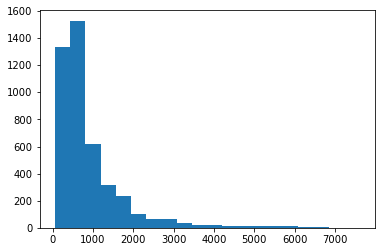

In [24]:
import matplotlib.pyplot as plt
plt.hist(validation_data['input_text'].str.len(), bins = 20)
plt.show()

In [25]:
input_text_val = list(validation_data['input_text'])
input_text_val[0]

'* where was sasha vujačić born *,* sasha vujačić *,* [ sex or gender , occupation , member of sports team , Commons category , position played on team / speciality , instance of , date of birth , place of birth , Freebase ID , country of citizenship , image , given name , Twitter username , sport , drafted by , Basketball-Reference.com NBA player ID , mass , height , ACB.com player ID , euroleague.net player ID , CONOR.SI ID , ESPN.com NBA player ID , sport number , RealGM basketball player ID , family name , LegaBasket.it player ID , Turkish Basketball Super League ID , work period (start , Eurobasket.com player ID , league , NBA.com player ID , country for sport , social media followers , Proballers ID , languages spoken , written or signed , Trading Card Database person ID ] *'

In [26]:
target_text_val = list(validation_data['target relation label'].astype(str))
target_text_val[0]

'place of birth'

In [27]:
X_val_tokenized = tokenizer(['relation_linking: ' + sequence for sequence in input_text_val], 
                              padding=True, 
                              truncation=True, 
                              max_length=max_source_length)

y_val_tokenized = tokenizer(target_text_val, 
                              padding=True, 
                              truncation=True, 
                              max_length=max_target_length)

print(len(validation_data))
# print(len(training_sample))

4412


In [28]:
train_dataset = Dataset(X_train_tokenized, y_train_tokenized)

In [29]:
val_dataset = Dataset(X_val_tokenized, y_val_tokenized)

In [30]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    "Relation_linking_final_sub_obj",
    evaluation_strategy ='steps',
    eval_steps = 1000, # Evaluation and Save happens every 50 steps
    logging_steps = 500,
    save_steps = 1000,
    save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    learning_rate = 1e-3,
    adam_epsilon = 1e-8,
    
    gradient_accumulation_steps =2,
    
    num_train_epochs = 5,
    report_to="wandb",
#     metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

In [31]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model, 
    args=training_args, 
    train_dataset= train_dataset,
    eval_dataset = val_dataset,
#     callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [32]:
trainer.train()

/home/HadyElkady/miniconda3/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 30884
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 19300
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


/home/HadyElkady/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
1000,0.042700,0.023349
2000,0.025000,0.018049
3000,0.026500,0.022299
4000,0.023300,0.013573
5000,0.014800,0.016774
6000,0.016300,0.015023
7000,0.017100,0.011540
8000,0.013900,0.011316
9000,0.014400,0.011694
10000,0.010200,0.010338


***** Running Evaluation *****
  Num examples = 4412
  Batch size = 4
Saving model checkpoint to Relation_linking_final_sub_obj/checkpoint-1000
Configuration saved in Relation_linking_final_sub_obj/checkpoint-1000/config.json
Model weights saved in Relation_linking_final_sub_obj/checkpoint-1000/pytorch_model.bin
/home/HadyElkady/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 4412
  Batch size = 4
Saving model checkpoint to Relation_linking_final_sub_obj/checkpoint-2000
Configuration saved in Relation_linking_final_sub_obj/checkpoint-2000/config.json
Model weights saved in Relation_linking_final_sub_obj/checkpoint-2000/pytorch_model.bin
/home/HadyElkady/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functio

Model weights saved in Relation_linking_final_sub_obj/checkpoint-13000/pytorch_model.bin
Deleting older checkpoint [Relation_linking_final_sub_obj/checkpoint-8000] due to args.save_total_limit
/home/HadyElkady/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 4412
  Batch size = 4
Saving model checkpoint to Relation_linking_final_sub_obj/checkpoint-14000
Configuration saved in Relation_linking_final_sub_obj/checkpoint-14000/config.json
Model weights saved in Relation_linking_final_sub_obj/checkpoint-14000/pytorch_model.bin
Deleting older checkpoint [Relation_linking_final_sub_obj/checkpoint-9000] due to args.save_total_limit
/home/HadyElkady/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: User

In [33]:
print('finished')

finished
